<a href="https://colab.research.google.com/github/smkirwan77/mares_sales/blob/main/tatts_dec_18_mare_ability_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

One thing to examine is if a mares older sister is a good producer is she likely to be one as well? if that is the case i will need to change my scrpaer and include the dams name somehow in the niece/nephew thier to see is the mare on offer following good or bad producers.

Also from the first model I did, it was clear that BT is overhyped in mare prices, is that hype filtering down to thier progeny prices?


**can get a nice bit of the prog tiers dams by merging in sale data from the sale sheets.** but still could look into scraping the extra pages that where sorted on stack overflow in january. Easy enough store them, just need to build a new function that loops over the desired horses url, then put the data into a new sheet.

# Intro

I will try look back and predict mare ability, both before they have any runners as well as after they have had a few etc. It must be noted that the generation/tier analised here will be confusing when looking back in time. A large part of this will be looking at the dams of the mares on offer (Thier best mark, there dams mean prog rating (2nd dams of mare on offer)). There is more complete data on this generational thier hence why I have picked this generation as a starting point.

In [183]:
##importing packages needed for this project
from bs4 import BeautifulSoup as bs
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
import sklearn.metrics as metrics

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
sns.color_palette("Spectral", as_cmap=True)
sns.set()

In [65]:
##below reads in all the sheets into a dictionary, with sheet names as the keys
all_data_sets = pd.read_excel('/content/drive/MyDrive/horse_racing/sale_work/bulk_scrape/2018_raw.xlsx', sheet_name=None)
print(all_data_sets.keys())

dict_keys(['sale_df', 'dam_sire_stats', 'prog_form_basic', 'prog_niece_nephew_form_basic', 'own_sib_form_basic', 'dams_aunt_uncles_form_basic', 'prog_sales', 'prog_niece_nephew_sales', 'own_sib_sales', 'dams_aunt_uncles_sales', 'own_sib_form_full', 'prog_niece_nephew_form_full', 'dams_aunts_uncles_form_full'])


#EDA - Broodmare ability
Starting by getting some metrics that can help predict a mares broomare ability.
mean prog rating to date, dam mean prog rating to date, race abilty, dam ability, these are some metrics to start. Progeny sales price another area to look at as well.

dam sire data would be too outdated at this stage, but have the python function built for upcoming sales. Have since discovered I can split the progeny by year. So can build another function that scapes the data by year and then filter out new data, no need yet. Its a function I will be building in the future I suspect, just want to get on with this for now.

### Mean max rating correlation X foal number.
Will cumilativly look at a mares mean prog max rating, I will then compare that to their final rating and see whereabouts do we start getting correlation. Starting by looking at the "own_sib" tier as that will have more suitable data.

In [125]:
##the data below will have been updated and contains info after the mares sales. will have to use the full form data set and filter down the data we would have had at the time later.
own_sib_basic_form_df = all_data_sets['own_sib_form_basic']
own_sib_basic_form_df = own_sib_basic_form_df.loc[own_sib_basic_form_df['mainType'] == 'FLAT']
own_sib_basic_form_df = own_sib_basic_form_df.sort_values(['sale_lot_no', 'horseYob'])
own_sib_basic_form_df.head(5) #can cases like horses like Across (USA) who won a us race and got plenty of money but a 0 rpr. I will try remove those examples. prob important to keep the shit 0's in there tough.
#there is just over 200 counts of 0 bestRpPostmark i will remove the ones who got more then 4 grand prize money as they likely should not be in there.

,mainType,horseUid,horseName,styleName,countryOriginCode,horseYob,horseSexCode,trainerName,trainerUid,runs,...,bestRpPostmark,avgFlatWinDistOfProgeny,distanceYard,distanceFurlong,winPercent,stakesWinnerOrPlaced,sale_lot_no,relationship,url_name,url
1,FLAT,1625975,Prolific,Prolific,USA,2015,G,Michael Stidham,8863,5,...,29.0,9.5,1540,7.0,20,False,1376,own_sib_basic_form,prolific,https://www.racingpost.com/profile/tab/horse/1...
2,FLAT,2785875,Across,Across,USA,2017,M,Brad H Cox,18362,3,...,0.0,8.5,1760,8.0,33,False,1376,own_sib_basic_form,across,https://www.racingpost.com/profile/tab/horse/2...
0,FLAT,3242550,Commandeer,Commandeer,USA,2018,G,James J Toner,11882,16,...,103.0,7.6,1980,9.0,19,True,1376,own_sib_basic_form,commandeer,https://www.racingpost.com/profile/tab/horse/3...
3,FLAT,4483088,Team Leader,Team Leader,USA,2020,G,Brendan P Walsh,26181,5,...,0.0,7.6,1430,6.5,20,False,1376,own_sib_basic_form,team-leader,https://www.racingpost.com/profile/tab/horse/4...
6,FLAT,788755,Rabbit Motivator,Rabbit Motivator,IRE,2008,H,Jan Blecha,20948,1,...,85.0,11.4,2640,12.0,0,False,1377,own_sib_basic_form,rabbit-motivator,https://www.racingpost.com/profile/tab/horse/7...


In [126]:
#remove 0 and ones who got prize money
own_sib_basic_form_df_2 = own_sib_basic_form_df.loc[~((own_sib_basic_form_df['totalPrizeMoney'] > 4000) & (own_sib_basic_form_df['bestRpPostmark'] == 0))]
own_sib_basic_form_df_2.head(8);

In [127]:
running_mean_prog_rating = own_sib_basic_form_df_2.dropna(subset = 'bestRpPostmark').groupby(['sale_lot_no'])['bestRpPostmark'].expanding().agg({'mean', 'count'})
running_mean_prog_rating.head()

mean  count
sale_lot_no                    
1376        1  29.000000    1.0
            0  66.000000    2.0
1377        6  85.000000    1.0
            4  88.000000    2.0
            7  58.666667    3.0

In [128]:
running_mean_prog_rating = running_mean_prog_rating.reset_index().drop(columns = 'level_1')
running_mean_prog_rating.head()

,sale_lot_no,mean,count
0,1376,29.000000,1.0
1,1376,66.000000,2.0
2,1377,85.000000,1.0
3,1377,88.000000,2.0
4,1377,58.666667,3.0


In [129]:
running_mean_prog_rating_foal_number = running_mean_prog_rating.pivot(columns ='count', values = 'mean', index = 'sale_lot_no')
running_mean_prog_rating_foal_number.head(10)

count,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
sale_lot_no,,,,,,,,,,,,,,,,
1376,29.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1377,85.0,88.0,58.666667,65.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1378,57.0,79.0,79.666667,89.25,80.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1380,64.0,68.0,76.000000,74.25,62.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1381,85.0,77.0,79.000000,87.75,85.8,86.333333,86.000000,82.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382,102.0,87.0,83.666667,85.75,79.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1383,70.0,83.0,91.666667,89.75,84.4,83.166667,87.142857,86.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,35.0,69.0,68.666667,75.50,76.6,80.000000,81.857143,81.750,82.333333,80.6,80.727273,NaN,NaN,NaN,NaN,NaN
1385,114.0,98.5,93.666667,87.00,90.2,88.166667,83.857143,73.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
dams_mean_prog_max_rating = own_sib_basic_form_df_2.dropna(subset = 'bestRpPostmark').groupby(['sale_lot_no'])['bestRpPostmark'].agg({'count','mean'}).rename(columns = {'count':'count_dams_prog_ratings', 'mean':'mean_dams_prog_rating'})
dams_mean_prog_max_rating.head()

,mean_dams_prog_rating,count_dams_prog_ratings
sale_lot_no,,
1376,66.0,2
1377,65.5,4
1378,80.8,5
1380,62.2,5
1381,82.0,8


In [131]:
dams_running_mean_prog_rating_foal_number = running_mean_prog_rating_foal_number.join(dams_mean_prog_max_rating)
dams_running_mean_prog_rating_foal_number.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,mean_dams_prog_rating,count_dams_prog_ratings
sale_lot_no,,,,,,,,,,,,,,,,,,
1376,29.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,2
1377,85.0,88.0,58.666667,65.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.5,4
1378,57.0,79.0,79.666667,89.25,80.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.8,5
1380,64.0,68.0,76.000000,74.25,62.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.2,5
1381,85.0,77.0,79.000000,87.75,85.8,86.333333,86.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,8


In [132]:
dams_running_mean_prog_rating_foal_number.corr()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,mean_dams_prog_rating,count_dams_prog_ratings
1.0,1.000000,0.736385,0.617164,0.571534,0.508991,0.443916,0.373122,0.400761,0.431399,0.433429,0.470067,0.568802,0.582431,-0.631270,-0.650452,-1.0,0.475994,0.058835
2.0,0.736385,1.000000,0.835161,0.763067,0.680005,0.619782,0.567636,0.536716,0.554579,0.572053,0.628347,0.689352,0.731192,-0.099998,0.117663,1.0,0.646746,0.150503
3.0,0.617164,0.835161,1.000000,0.876734,0.773104,0.703799,0.660579,0.615702,0.624210,0.623144,0.641053,0.699978,0.808229,0.525897,0.166952,1.0,0.739765,0.186407
4.0,0.571534,0.763067,0.876734,1.000000,0.904924,0.820473,0.763424,0.720934,0.706743,0.732312,0.746633,0.839464,0.899919,0.731890,0.547949,1.0,0.825175,0.196013
5.0,0.508991,0.680005,0.773104,0.904924,1.000000,0.915556,0.864694,0.804325,0.808246,0.817801,0.806130,0.875350,0.873691,0.811572,0.793475,1.0,0.874144,0.160240
6.0,0.443916,0.619782,0.703799,0.820473,0.915556,1.000000,0.943787,0.880894,0.881602,0.889406,0.876530,0.889460,0.898508,0.948579,0.926026,1.0,0.907970,0.141696
7.0,0.373122,0.567636,0.660579,0.763424,0.864694,0.943787,1.000000,0.943608,0.922704,0.924958,0.914285,0.885963,0.892448,0.902890,0.861381,1.0,0.929253,0.084132
8.0,0.400761,0.536716,0.615702,0.720934,0.804325,0.880894,0.943608,1.000000,0.966039,0.951354,0.934951,0.900486,0.892045,0.872663,0.711256,1.0,0.950473,0.065245
9.0,0.431399,0.554579,0.624210,0.706743,0.808246,0.881602,0.922704,0.966039,1.000000,0.980018,0.959787,0.931794,0.925562,0.836337,0.621277,1.0,0.964314,0.121703
10.0,0.433429,0.572053,0.623144,0.732312,0.817801,0.889406,0.924958,0.951354,0.980018,1.000000,0.978956,0.955864,0.958436,0.847691,0.679453,1.0,0.974412,0.043846


The above table suggests it is dangerous to judge a mare after 1 foal. even 2/3 foals is risky. After 4/5 foals we have a fair idea. Baring in mind horse age is a factor in sales, I'd be happy to chance a mare after 3 particularly if there were nice sires to come or if the coming progeny sold well. After 4 racing foals we have a strong idea, bearing in mind actually the above table would have the max ratings after the horses retired and if we are looking at a fertile mare with 3 runners then there would only haven been one to get the chance to race at 4 so probably should'nt be too harah on her (element tough of things have to happen quick in this game which balances things out a touch).

**The above suggests our model might be better not including mares with only 1 runner**. But I won't get too bogged down on it anyway.

### foal number vs max rating
Quick look at when does a mare produce their best foals. will compare the foal number to average of what the mare achieved and then take the average of the columns. If I did'nt compare it mare for mare I suspect the older columns would be skewed by the market keeping onto mares tthat have made the grade as well as the market getting rid of mares that are not good enough.


In [133]:
ratings = own_sib_basic_form_df_2.dropna(subset = 'bestRpPostmark')[['sale_lot_no', 'bestRpPostmark', 'horseYob', 'horseName']]
ratings.head(20)

,sale_lot_no,bestRpPostmark,horseYob,horseName
1,1376,29.0,2015,Prolific
0,1376,103.0,2018,Commandeer
6,1377,85.0,2008,Rabbit Motivator
4,1377,91.0,2010,Almanack
7,1377,0.0,2011,Painted Black
5,1377,86.0,2013,Pride Of Angels
11,1378,57.0,2008,Minkie Moon
9,1378,101.0,2009,East Meets West
10,1378,81.0,2010,Thorpe
8,1378,118.0,2012,Magic Circle


In [134]:
ratings['foal_count'] = own_sib_basic_form_df_2.dropna(subset = 'bestRpPostmark').groupby(['sale_lot_no'])['bestRpPostmark'].cumcount() + 1
ratings.head()

,sale_lot_no,bestRpPostmark,horseYob,horseName,foal_count
1,1376,29.0,2015,Prolific,1
0,1376,103.0,2018,Commandeer,2
6,1377,85.0,2008,Rabbit Motivator,1
4,1377,91.0,2010,Almanack,2
7,1377,0.0,2011,Painted Black,3


In [135]:
dams_foal_number_ratings = ratings.pivot(index = 'sale_lot_no',  columns = 'foal_count', values = 'bestRpPostmark')
dams_foal_number_ratings = dams_foal_number_ratings.join(dams_mean_prog_max_rating.drop(columns = 'count_dams_prog_ratings'))
dams_foal_number_ratings.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,mean_dams_prog_rating
sale_lot_no,,,,,,,,,,,,,,,,,
1376,29.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0
1377,85.0,91.0,0.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.5
1378,57.0,101.0,81.0,118.0,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.8
1380,64.0,72.0,92.0,69.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.2
1381,85.0,69.0,83.0,114.0,78.0,89.0,84.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0


In [136]:
dams_foal_number_ratios = dams_foal_number_ratings.div(dams_foal_number_ratings['mean_dams_prog_rating'], axis = 0)
dams_foal_number_ratios.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,mean_dams_prog_rating
sale_lot_no,,,,,,,,,,,,,,,,,
1376,0.439394,1.560606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1377,1.297710,1.389313,0.000000,1.312977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1378,0.705446,1.250000,1.002475,1.460396,0.581683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1380,1.028939,1.157556,1.479100,1.109325,0.225080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1381,1.036585,0.841463,1.012195,1.390244,0.951220,1.085366,1.024390,0.658537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1382,1.284635,0.906801,0.969773,1.158690,0.680101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1383,0.813953,1.116279,1.267442,0.976744,0.732558,0.895349,1.290698,0.906977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1384,0.433559,1.275901,0.842342,1.189189,1.003378,1.201577,1.152027,1.003378,1.077703,0.805180,1.015766,NaN,NaN,NaN,NaN,NaN,1.0
1385,1.553663,1.131175,1.144804,0.913118,1.403748,1.063032,0.790460,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


<Axes: >

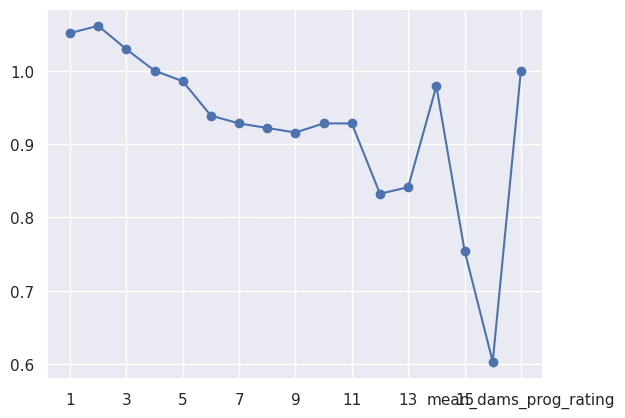

In [137]:
dams_foal_number_ratios.mean(axis = 0).plot(marker = 'o')

#### Foal number ratings
Very interesting how the trend goes down with time. I suspect the variance at the end will be down to small samples. The above slope is prob worsened by the fact that a mare still producing is proven and are probably going to better sire but yet the trend is still slipping.

The above would also dismiss the first foal theory in the industry. First foals do very well, 2nd best overall. **Must see is that played out in the market at a later stage.** At this moment in time its not the biggest edge to my eye when you look at the scale, **surely youd be better off seing the mares first 5 foals and knowing shes good** rather then guessing what she can do.

**However Tom Wilson reasearch would suggest the above is more significant then I initially tought**. As it stands he thinks theres an edge in the market striking early, however given how hard I've found it to predict broodmare ability below I have to think the solution lies in the middle somewhere, I realy suspect I need to see a mares progeny ratings/sales to be confident buying a mare at present.
https://tomwilson1986.medium.com/unexposed-pedigrees-the-explainability-paradox-0253e7fd9449

### %above 80,90,100 etc

In [138]:
above_80 = pd.DataFrame()
for i in dams_foal_number_ratings.columns[:-1]:
  dams_foal_number_ratings.loc[dams_foal_number_ratings[i] >= 80, f"{i}_above_80"] = 1
  dams_foal_number_ratings.loc[dams_foal_number_ratings[i] < 80, f"{i}_above_80"] = 0
  above_80[f"{i}_above_80"] = dams_foal_number_ratings[f"{i}_above_80"]
  dams_foal_number_ratings = dams_foal_number_ratings.drop(columns = f"{i}_above_80")

above_80_per = above_80.expanding(axis=1).mean() # abit anoying we loose the nans. will examine the table now anyway for corelation
above_80_per.head()

,1_above_80,2_above_80,3_above_80,4_above_80,5_above_80,6_above_80,7_above_80,8_above_80,9_above_80,10_above_80,11_above_80,12_above_80,13_above_80,14_above_80,15_above_80,16_above_80
sale_lot_no,,,,,,,,,,,,,,,,
1376,0.0,0.5,0.500000,0.50,0.50,0.500000,0.500000,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500
1377,1.0,1.0,0.666667,0.75,0.75,0.750000,0.750000,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750
1378,0.0,0.5,0.666667,0.75,0.60,0.600000,0.600000,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600,0.600
1380,0.0,0.0,0.333333,0.25,0.20,0.200000,0.200000,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200,0.200
1381,1.0,0.5,0.666667,0.75,0.60,0.666667,0.714286,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625,0.625


In [139]:
##column 16 represents the final % vale above 80 for all mares above. so it will do as the one to compare correlation against.
above_80_per.corr()

,1_above_80,2_above_80,3_above_80,4_above_80,5_above_80,6_above_80,7_above_80,8_above_80,9_above_80,10_above_80,11_above_80,12_above_80,13_above_80,14_above_80,15_above_80,16_above_80
1_above_80,1.000000,0.737838,0.628629,0.581934,0.543814,0.523933,0.515685,0.512815,0.510200,0.509292,0.510364,0.509314,0.509203,0.509404,0.508966,0.508760
2_above_80,0.737838,1.000000,0.848549,0.788799,0.752682,0.723795,0.710134,0.699077,0.699133,0.698544,0.698740,0.697960,0.697693,0.698049,0.697619,0.697350
3_above_80,0.628629,0.848549,1.000000,0.911698,0.862567,0.828629,0.815220,0.803698,0.801416,0.801965,0.800566,0.799473,0.799269,0.799468,0.799035,0.798839
4_above_80,0.581934,0.788799,0.911698,1.000000,0.945630,0.909006,0.894926,0.882248,0.876760,0.876260,0.874980,0.873638,0.873039,0.873326,0.872962,0.872703
5_above_80,0.543814,0.752682,0.862567,0.945630,1.000000,0.968778,0.953790,0.942973,0.936488,0.934928,0.933432,0.932219,0.931323,0.931728,0.931313,0.931008
6_above_80,0.523933,0.723795,0.828629,0.909006,0.968778,1.000000,0.983619,0.972976,0.967934,0.965699,0.964355,0.963353,0.962331,0.962556,0.962204,0.961947
7_above_80,0.515685,0.710134,0.815220,0.894926,0.953790,0.983619,1.000000,0.989411,0.982877,0.980985,0.980176,0.978954,0.978220,0.978308,0.978086,0.977936
8_above_80,0.512815,0.699077,0.803698,0.882248,0.942973,0.972976,0.989411,1.000000,0.995407,0.992647,0.992110,0.990760,0.990045,0.990087,0.989830,0.989696
9_above_80,0.510200,0.699133,0.801416,0.876760,0.936488,0.967934,0.982877,0.995407,1.000000,0.997791,0.997434,0.996568,0.996045,0.995944,0.995785,0.995725
10_above_80,0.509292,0.698544,0.801965,0.876260,0.934928,0.965699,0.980985,0.992647,0.997791,1.000000,0.999154,0.998414,0.998198,0.998077,0.998038,0.998038


simlar story as when looking at the ratings. **but % above 80 looks more correlated** . will have to come up with a way to split the df up so that we use the first x foals to predict the next y foals. atm what I have been looking at is the first x being used to predict the overall score which has the x amount in it making it more accurate. that has been the case for both mean ratings and above 80 rating.

### predicting future using past
as stated above will try and use past data that predicyts future data w/o the past data getting caught up in it.

sample size : 121


<Axes: >

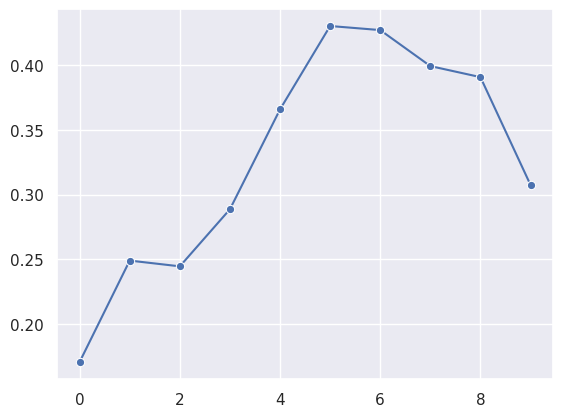

In [140]:
##will reduce it mares with x or more foals for now. hopefully not mudering sample size here.
foals = 10
busy_mares = dams_foal_number_ratings.dropna(subset = [foals])
correlation = []
print(f"sample size : {busy_mares.shape[0]}")
for i in range(1,foals+1):
  first_x_foals = busy_mares.iloc[:,:i]
  first_x_foals_mean = first_x_foals.mean(axis=1)
  last_y_foals = busy_mares.iloc[:,i:-1]
  last_y_foals_mean = last_y_foals.mean(axis =1)
  before_after = pd.concat([first_x_foals_mean, last_y_foals_mean], axis = 1)
  #print(before_after.head())
  #print(before_after.corr())
  correlation.append(before_after.corr().iloc[0,1])
sns.lineplot(correlation, marker = 'o')
#must note the below graph to add 1 to the x axis to represent how many past foal ratings used to predict future ratings.

we can see that the correlation has gone down dramtically when you take the old data out of the overall mean. thankfully i looked back on this. we can see as well the more foals the better. in order to keep sample size up i had it cut off at 7 foals. since the tail dipped below i am going to look at mares with 10 foals to see was 6 foals the point where it tailed off. **still a correlation of 0.3 ish for 4 foals** is decent (remember add 1 to above graph for number of past foals in sample)

**It has platowed at 6 foals. I'm sure the more the better in realty but those oppurtunities are rare.**

### mares racing ability versus her broodmare average prog.

merging in dams ratings as we have been looking at the ability of the dams of the mares on offers broodmare ability.

In [141]:
sale_df = all_data_sets['sale_df']
dams_aunt_uncles_form_basic_df = all_data_sets['dams_aunt_uncles_form_basic']
dams_aunt_uncles_form_basic_df = dams_aunt_uncles_form_basic_df.loc[dams_aunt_uncles_form_basic_df['mainType'] == 'FLAT']
dams_aunt_uncles_form_basic_df_2 = dams_aunt_uncles_form_basic_df.loc[~((dams_aunt_uncles_form_basic_df['totalPrizeMoney'] > 4000) & (dams_aunt_uncles_form_basic_df['bestRpPostmark'] == 0))]
##above cleans out the cases that have a rating of 0 when they deserved a rating (might have got one due the area they raced in)
dams_names = sale_df['dam_style_name']
dams_form_basic_df = dams_aunt_uncles_form_basic_df_2.loc[dams_aunt_uncles_form_basic_df_2['horseName'].isin(dams_names)]

dams_ratings = dams_form_basic_df[['horseName', 'sale_lot_no', 'bestRpPostmark']]
dams_ratings.head()

,horseName,sale_lot_no,bestRpPostmark
34,Grace O'Malley,1379,101.0
41,Sister Red,1380,82.0
49,Fabulous Fairy,1381,77.0
63,Gleaming Water,1383,NaN
76,Bright Halo,1384,NaN


<Axes: xlabel='bestRpPostmark', ylabel='Count'>

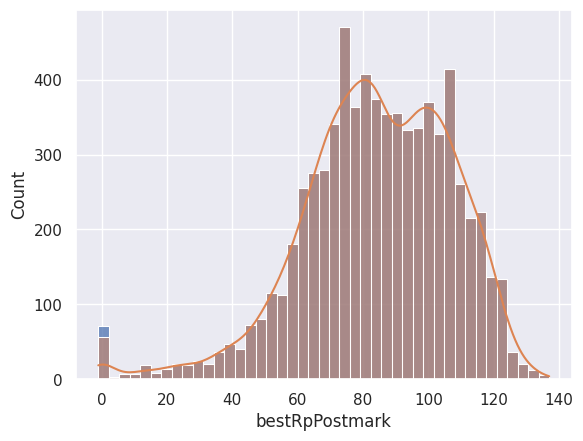

In [142]:
sns.histplot(dams_aunt_uncles_form_basic_df, x = 'bestRpPostmark')
sns.histplot(dams_aunt_uncles_form_basic_df_2, x = 'bestRpPostmark', kde = True) ##just a quick demo of how we removed a few 0's without removing them all, as hoped.

<Axes: xlabel='bestRpPostmark', ylabel='Count'>

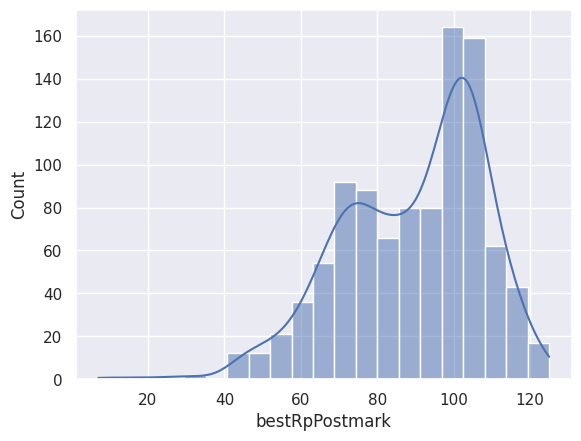

In [143]:
sns.histplot(dams_ratings, x = 'bestRpPostmark', kde = True)

 The kde line shows here how the industrty doesnt really breed off poor mares. the portion of ratings below 40 is much lower in the dams dataset compared to the dam_aunts_uncles part. which suggests fillies that where useless on the track didnt go the shed as much as others. makes sense but industry looks to overplay this based on Tom wilsons analysis.

In [144]:
dams_df = dams_ratings.merge(dams_mean_prog_max_rating, on = 'sale_lot_no', how = 'left')#.dropna()
print(f"sample size : {dams_df.dropna().shape[0]}")
dams_df.head()

sample size : 990


,horseName,sale_lot_no,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings
0,Grace O'Malley,1379,101.0,NaN,NaN
1,Sister Red,1380,82.0,62.200000,5.0
2,Fabulous Fairy,1381,77.0,82.000000,8.0
3,Gleaming Water,1383,NaN,86.000000,8.0
4,Bright Halo,1384,NaN,80.727273,11.0


In [145]:
dams_df.drop(columns = {'horseName'}).corr()

,sale_lot_no,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings
sale_lot_no,1.000000,-0.112048,-0.211550,-0.120777
bestRpPostmark,-0.112048,1.000000,0.156714,-0.004837
mean_dams_prog_rating,-0.211550,0.156714,1.000000,0.165713
count_dams_prog_ratings,-0.120777,-0.004837,0.165713,1.000000


0.15 correlation for a large sample. shows that proven mares are better then faster mares. will see is there multicolinearity. im sure there is, will see do they cancel each other out to some degree. i.e is an unproven fast mare going to be twice (going for twice as Im kind of taking prog ratings as correlation 0.3) as likely a success then a slow mare.

**hang on am i getting cought up here in correlation rather then slope again?**
will stay going with other things for now. how else can i predict a mares abilty?? dams broodmare ability.

#predicting dams broodmare ability
closer look at the rating of the mare in question and the mean of thier dams progeny ratings.




In [146]:
scnd_dams_prog_ratings = dams_aunt_uncles_form_basic_df.groupby('sale_lot_no')['bestRpPostmark'].agg({'count', 'mean'}).rename(columns = {'count': 'count_scnd_dams_prog_ratings', 'mean': 'scnd_dams_mean_prog_ratings'})
scnd_dams_prog_ratings.head()

,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings
sale_lot_no,,
1376,72.600000,5
1377,83.363636,11
1378,94.777778,9
1379,99.666667,6
1380,79.666667,6


In [147]:
dams_df.head()

,horseName,sale_lot_no,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings
0,Grace O'Malley,1379,101.0,NaN,NaN
1,Sister Red,1380,82.0,62.200000,5.0
2,Fabulous Fairy,1381,77.0,82.000000,8.0
3,Gleaming Water,1383,NaN,86.000000,8.0
4,Bright Halo,1384,NaN,80.727273,11.0


In [148]:
#merge into a df. start building a df that will be used to model a mares future foal ratings. this is starting to take shape. i will be confused in the morning.
dams_df = dams_df.set_index('sale_lot_no')
dams_df = dams_df.join(scnd_dams_prog_ratings)
dams_df.head(7)

,horseName,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings
sale_lot_no,,,,,,
1379,Grace O'Malley,101.0,NaN,NaN,99.666667,6
1380,Sister Red,82.0,62.200000,5.0,79.666667,6
1381,Fabulous Fairy,77.0,82.000000,8.0,85.000000,5
1383,Gleaming Water,NaN,86.000000,8.0,76.500000,6
1384,Bright Halo,NaN,80.727273,11.0,97.900000,10
1385,Zanzibar,112.0,73.375000,8.0,82.333333,6
1386,Welsh Diva,109.0,58.363636,11.0,82.846154,13


In [149]:
scnd_dams_prog_ratings.head()

,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings
sale_lot_no,,
1376,72.600000,5
1377,83.363636,11
1378,94.777778,9
1379,99.666667,6
1380,79.666667,6


In [150]:
dams_df.head()

,horseName,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings
sale_lot_no,,,,,,
1379,Grace O'Malley,101.0,NaN,NaN,99.666667,6
1380,Sister Red,82.0,62.200000,5.0,79.666667,6
1381,Fabulous Fairy,77.0,82.000000,8.0,85.000000,5
1383,Gleaming Water,NaN,86.000000,8.0,76.500000,6
1384,Bright Halo,NaN,80.727273,11.0,97.900000,10


In [151]:
dams_df.index.value_counts().sort_values()

sale_lot_no
2309    1
1426    1
1427    1
1430    1
1431    1
       ..
2303    3
1486    3
1485    3
1726    3
1788    3
Name: count, Length: 899, dtype: int64

In [152]:
dams_df[['mean_dams_prog_rating', 'scnd_dams_mean_prog_ratings','bestRpPostmark']].corr()

,mean_dams_prog_rating,scnd_dams_mean_prog_ratings,bestRpPostmark
mean_dams_prog_rating,1.000000,0.202946,0.156714
scnd_dams_mean_prog_ratings,0.202946,1.000000,0.387249
bestRpPostmark,0.156714,0.387249,1.000000


The above suggests a mares dams producing ability is better correlated then the mares itself racecourse ability. The slopes will be interesting. will build a small model to have a look now.

array([[<Axes: title={'center': 'bestRpPostmark'}>,
        <Axes: title={'center': 'mean_dams_prog_rating'}>],
       [<Axes: title={'center': 'scnd_dams_mean_prog_ratings'}>,
        <Axes: >]], dtype=object)

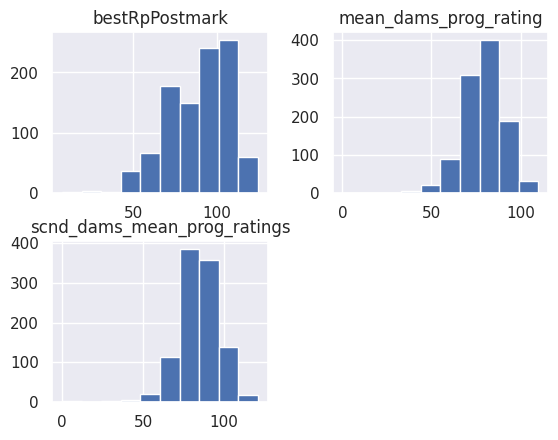

In [153]:
dams_df.drop(columns = {'count_dams_prog_ratings', 'count_scnd_dams_prog_ratings'}).hist()

In [154]:
data = dams_df.dropna()
x = data[['bestRpPostmark', 'scnd_dams_mean_prog_ratings']]
y = data['mean_dams_prog_rating']
print(data.shape)

(990, 6)


In [155]:
coefficients = pd.DataFrame()
model = LinearRegression()
model.fit(x, y)
r2_score = model.score(x, y)
print(f"r2_score : {r2_score}")
coef = pd.DataFrame(model.coef_, index = [x.columns], columns = ['coeficient']).transpose()
coef

r2_score : 0.05061780419180195


,bestRpPostmark,scnd_dams_mean_prog_ratings
coeficient,0.053926,0.166523


<Axes: xlabel='bestRpPostmark_bin'>

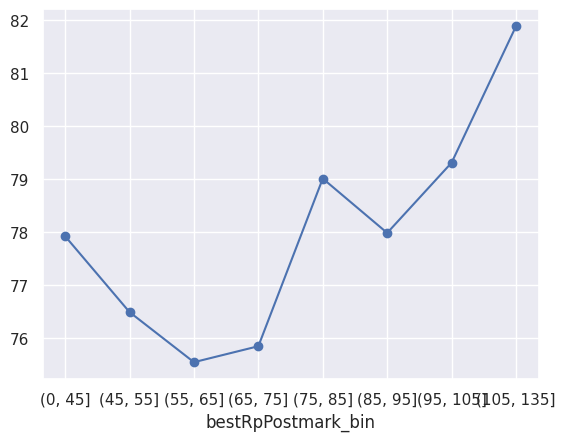

In [156]:
dams_df['bestRpPostmark_bin'] = pd.cut(dams_df['bestRpPostmark'], bins = [0, 45,55,65,75,85,95,105,135])
dams_df.groupby(['bestRpPostmark_bin'])['mean_dams_prog_rating'].mean().plot(marker = 'o') #5 lb swing for such a wide range of ratings. very low slope in the context of the cost of mares.
##gas we have the same finding as TW the useless ones still produce better then the poor ones. I have to guess this is beacuse the mares where tried based on good homework but a non hiertery issue held them back. amazing, you can spend millions on a superstare mare but only be 3lb better then a injured one.

##### Note
The above sugeests that the dam of the mares ability to produce good horses is more impoirtant then the mare itselfs racecourse ability. The slope is 3 times that of the mares racing ability and the correlation is higher too boot (0.2 vs 0.15). **This is a cool finding and one that should be looked into to see how the market weighs these things.** Also must be noted how poor the model is at predicting a mares abilty using the above metrics. **This is dissapointing.**
but its something the below found as well. **sire data is likely to be a help, i.e mares going to better sires will help them**. note: When the quality of racehorse a broodmare was, that is something I have over looked at when predicting sires. **I was using mares ratings, in hindsight a mares broodmare ability would have been a much better uplift metric. Thats something I will try note for 2025.**

https://tomwilson1986.medium.com/does-the-ability-of-the-dam-correlate-with-the-ability-of-her-offspring-d1964dfa1e39

**Looking at my 2023 analysis it looks like the market is picking up the prog ratings is more significant**. But I should have a better look, the decimals where tiny. I'll prob build a model using just the 2 metrics. Shame that the data above consists of the mares dams and 2nd dams rather the mares on offer as then I could have built a model here straighaway.

Also I should note I can only imagine that the number of foals is sigificant for the reliabilty of the dams_mean_prog_rating as a predictor variable. just like the mares on offer as well.

Another angle. It effects racehorses. does it effect what foal number a mare is as a broodmare? that will be hard to get a suitable df of data with.

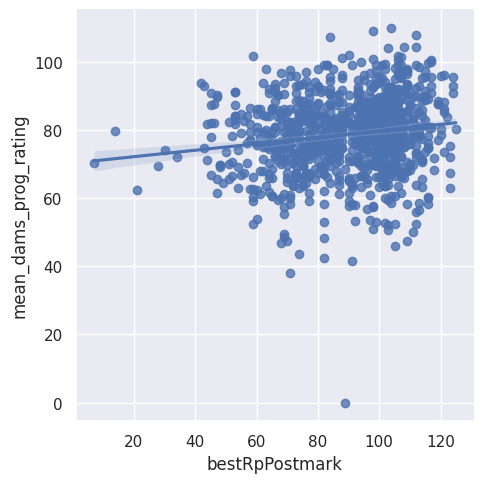

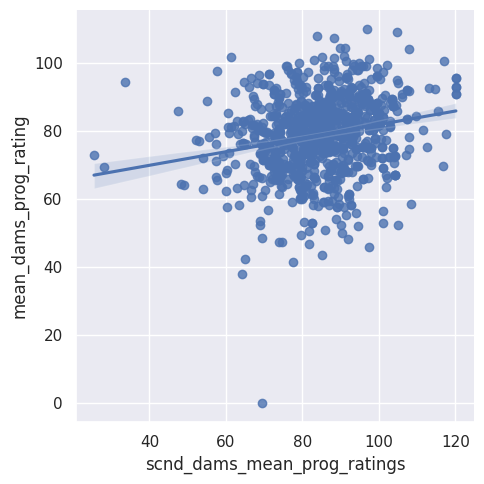

In [157]:
##want to view the above on a scatterplot.
sns.lmplot(data = data , x = 'bestRpPostmark', y = 'mean_dams_prog_rating')
sns.lmplot(data = data , x = 'scnd_dams_mean_prog_ratings', y = 'mean_dams_prog_rating')

In [158]:
##quick check for multicolinearity. #of course these are correlated as the bestRpPostmark figure is one of the numbers that calculates the dams_mean_prog_rating, they would be less corelated the larger the dams foals sample size
x.corr()

,bestRpPostmark,scnd_dams_mean_prog_ratings
bestRpPostmark,1.000000,0.386831
scnd_dams_mean_prog_ratings,0.386831,1.000000


In [159]:
##will build a model using 1 variable each.
coefficients = pd.DataFrame()
model = LinearRegression()
model.fit(x.drop(columns = {'scnd_dams_mean_prog_ratings'}), y)
r2_score = model.score(x.drop(columns = {'scnd_dams_mean_prog_ratings'}), y)
print(f"r2_score : {r2_score}")
coef = pd.DataFrame(model.coef_, index = [x.drop(columns = {'scnd_dams_mean_prog_ratings'}).columns], columns = ['coeficient']).transpose()
coef

r2_score : 0.024559264612797893


,bestRpPostmark
coeficient,0.094957


In [160]:
##will build a model using 1 variable each.
coefficients = pd.DataFrame()
model = LinearRegression()
model.fit(x.drop(columns = {'bestRpPostmark'}), y)
r2_score = model.score(x.drop(columns = {'bestRpPostmark'}), y)
print(f"r2_score : {r2_score}")
coef = pd.DataFrame(model.coef_, index = [x.drop(columns = {'bestRpPostmark'}).columns], columns = ['coeficient']).transpose()
coef

r2_score : 0.04388245684454106


,scnd_dams_mean_prog_ratings
coeficient,0.199272


We can see that the r scores with them individually are lower. however there is much of a muchness really when looking at the dams mean prog ratings and its usually best to have a lesser amount of variables. The coefficient is higher when you dont include rating as well. Contemplated stripping out the mares rating from the dams mean part to reduce multicolinearity of the variables but whats the point. The rating makes a fraction of the impact that the dams mean prog rating does so why negate that variable just to complecate the model and more then likely just have a lesser model.

In [161]:
dams_df.head()

,horseName,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings,bestRpPostmark_bin
sale_lot_no,,,,,,,
1379,Grace O'Malley,101.0,NaN,NaN,99.666667,6,"(95.0, 105.0]"
1380,Sister Red,82.0,62.200000,5.0,79.666667,6,"(75.0, 85.0]"
1381,Fabulous Fairy,77.0,82.000000,8.0,85.000000,5,"(75.0, 85.0]"
1383,Gleaming Water,NaN,86.000000,8.0,76.500000,6,NaN
1384,Bright Halo,NaN,80.727273,11.0,97.900000,10,NaN


In [162]:
## will filter on both counts and see how that effects correlation
for i in range(1,11):
  temp_df = dams_df.loc[(dams_df['count_dams_prog_ratings'] > i) & (dams_df['count_scnd_dams_prog_ratings'] > i)]
  print(f"count: {i}", temp_df[['mean_dams_prog_rating', 'scnd_dams_mean_prog_ratings']].corr())

count: 1                              mean_dams_prog_rating  \
mean_dams_prog_rating                     1.000000   
scnd_dams_mean_prog_ratings               0.184454   

                             scnd_dams_mean_prog_ratings  
mean_dams_prog_rating                           0.184454  
scnd_dams_mean_prog_ratings                     1.000000  
count: 2                              mean_dams_prog_rating  \
mean_dams_prog_rating                      1.00000   
scnd_dams_mean_prog_ratings                0.18424   

                             scnd_dams_mean_prog_ratings  
mean_dams_prog_rating                            0.18424  
scnd_dams_mean_prog_ratings                      1.00000  
count: 3                              mean_dams_prog_rating  \
mean_dams_prog_rating                     1.000000   
scnd_dams_mean_prog_ratings               0.229211   

                             scnd_dams_mean_prog_ratings  
mean_dams_prog_rating                           0.229211  
scnd_dams_me

### Yearling prices to help predict racehorse abilty - reduce nans
if we can use yearling price as a predictor we can use it to fill in missing data (A horse might never have made the track because of injury) Or it could be used to estimate what it will do going forward.

In [163]:
dams_aunt_uncles_sales = all_data_sets['dams_aunt_uncles_sales']
dam_sales = dams_aunt_uncles_sales.loc[dams_aunt_uncles_sales['horseName'].isin(dams_names)] ## have the dams names from earlier
dam_yr_sales = dam_sales.loc[dam_sales['horseAge'] == 1]
print(f"df size: {dam_yr_sales.shape}")
dam_yr_sales.head()

df size: (479, 29)


,saleDate,lotNo,horseUid,horseName,horseSaleName,horseAge,horseYob,horseFirstColourCode,horseSecondColourCode,horseSex,...,sireOfDamCountryOriginCode,buyerDetail,price,priceGbp,venueDesc,venueUid,curCode,vendor,sale_lot_no,relationship
75,2007-10-09,134,707058.0,Grace O'Malley,GRACE O'MALLEY,1.0,2006.0,B,NaN,F,...,GB,Bobby O'Ryan,140000.0,147000.0,TATTERSALLS,5,GNS,"From Hawthorn Villa Stud, Ireland",1379,aunt_uncle_sales
110,2009-08-25,125,749433.0,Sister Red,SISTER RED,1.0,2008.0,B,NaN,F,...,USA,Peter Doyle Bloodstock Ltd,22000.0,22000.0,GOFFS UK,44,GBP,"From Ballyhane, Ireland",1380,aunt_uncle_sales
203,1999-10-15,868,533892.0,Zanzibar,ZANZIBAR,1.0,1998.0,B,NaN,F,...,GB,Kern/Lillingston Association,40000.0,42000.0,TATTERSALLS,5,GNS,Property of a Partnership from Milton Park Stud,1385,aunt_uncle_sales
333,2004-10-07,521,658090.0,Mamonta,MAMONTA,1.0,2003.0,B,NaN,F,...,USA,Henry Candy,45000.0,47250.0,TATTERSALLS,5,GNS,From Woodcote Stud,1389,aunt_uncle_sales
452,2004-10-07,359,656653.0,Scylla Cadeaux,SCYLLA CADEAUX,1.0,2003.0,CH,NaN,F,...,USA,B B A Ireland,70000.0,73500.0,TATTERSALLS,5,GNS,Property of Newsells Park Stud from Voute Sale...,1394,aunt_uncle_sales


In [164]:
dam_yr_sales.columns

Index(['saleDate', 'lotNo', 'horseUid', 'horseName', 'horseSaleName',
       'horseAge', 'horseYob', 'horseFirstColourCode', 'horseSecondColourCode',
       'horseSex', 'horseCountryOriginCode', 'sireUid', 'sireName',
       'sireCountryOriginCode', 'damUid', 'damName', 'damCountryOriginCode',
       'sireOfDamUid', 'sireOfDamName', 'sireOfDamCountryOriginCode',
       'buyerDetail', 'price', 'priceGbp', 'venueDesc', 'venueUid', 'curCode',
       'vendor', 'sale_lot_no', 'relationship'],
      dtype='object')

In [165]:
dam_yr_sales = dam_yr_sales[['saleDate', 'priceGbp', 'sale_lot_no', 'horseYob']].set_index('sale_lot_no')
dam_yr_sales_sold = dam_yr_sales.loc[dam_yr_sales['priceGbp'] > 200]
dam_yr_sales_sold.head() ###make sure this is rigth, similar code was well off below.

,saleDate,priceGbp,horseYob
sale_lot_no,,,
1379,2007-10-09,147000.0,2006.0
1380,2009-08-25,22000.0,2008.0
1385,1999-10-15,42000.0,1998.0
1389,2004-10-07,47250.0,2003.0
1394,2004-10-07,73500.0,2003.0


In [166]:
dams_df = dams_df.join(dam_yr_sales_sold)
dams_df.head()

,horseName,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings,bestRpPostmark_bin,saleDate,priceGbp,horseYob
sale_lot_no,,,,,,,,,,
1379,Grace O'Malley,101.0,NaN,NaN,99.666667,6,"(95.0, 105.0]",2007-10-09,147000.0,2006.0
1380,Sister Red,82.0,62.200000,5.0,79.666667,6,"(75.0, 85.0]",2009-08-25,22000.0,2008.0
1381,Fabulous Fairy,77.0,82.000000,8.0,85.000000,5,"(75.0, 85.0]",NaN,NaN,NaN
1383,Gleaming Water,NaN,86.000000,8.0,76.500000,6,NaN,NaN,NaN,NaN
1384,Bright Halo,NaN,80.727273,11.0,97.900000,10,NaN,NaN,NaN,NaN


In [167]:
print(f"sample size: {dams_df[['priceGbp','bestRpPostmark']].dropna().shape[0]}")
dams_df[['priceGbp','bestRpPostmark']].corr()

sample size: 471


,priceGbp,bestRpPostmark
priceGbp,1.000000,0.065729
bestRpPostmark,0.065729,1.000000


In [168]:
dams_df['log_dams_yr_price'] = np.log(dams_df['priceGbp'])
print(f"sample size: {dams_df[['log_dams_yr_price','bestRpPostmark']].dropna().shape[0]}")
dams_df[['log_dams_yr_price', 'bestRpPostmark']].corr()

sample size: 471


,log_dams_yr_price,bestRpPostmark
log_dams_yr_price,1.000000,0.104282
bestRpPostmark,0.104282,1.000000


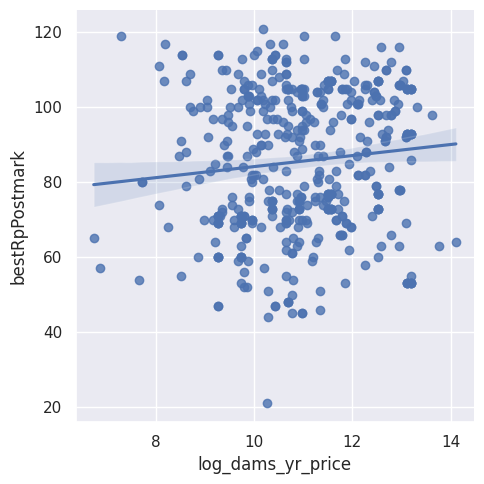

In [169]:
sns.lmplot(data = dams_df.loc[dams_df['priceGbp'] > 0], x = 'log_dams_yr_price', y ='bestRpPostmark') #removing when price is 0 as log 0 is inf.
###can get a better sample size to check this out. Ive murdered sample size here.

<Axes: xlabel='bestRpPostmark_bin'>

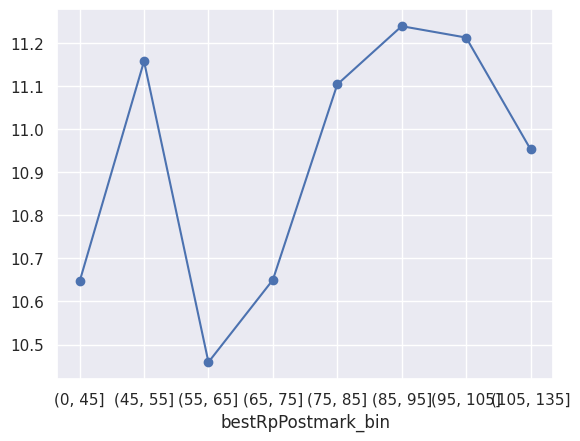

In [170]:
dams_df.loc[dams_df['priceGbp'] > 0].groupby('bestRpPostmark_bin')['log_dams_yr_price'].mean().plot(marker = 'o') #removing when price is 0 as log 0 is inf.

In [171]:
dams_df.loc[dams_df['priceGbp'] > 0].groupby('bestRpPostmark_bin')['log_dams_yr_price'].count() #removing when price is 0 as log 0 is inf.

bestRpPostmark_bin
(0, 45]         5
(45, 55]       28
(55, 65]       37
(65, 75]       97
(75, 85]       62
(85, 95]       60
(95, 105]     109
(105, 135]     73
Name: log_dams_yr_price, dtype: int64

Im very suprised at how poor yearling prices are correlted to predicting bestRP mark. Can this really be believed?

Anyway the main take away from the above is that its going to be too hard to use sale price to enhance missing data. **yr sale price im sure has a place in predicting a mares profitability.** And will be used again below.

I will have a better look at yearling/young horse price below.

In [172]:
##dont have to worry about dams as if a horse isnt named then it womt have a rating, dam names was used to create a ne wid column in previous researh.
sales = dams_aunt_uncles_sales[['horseName', 'horseYob', 'priceGbp', 'horseAge']]
young_sales_dams_aunts_uncles = sales.loc[sales['horseAge'] <= 2]
max_young_sales_dams_aunts_uncles = young_sales_dams_aunts_uncles.groupby('horseName')['priceGbp'].idxmax().dropna()

In [173]:
young_sales_dams_aunts_uncles.groupby('horseName')['priceGbp'].idxmax().dropna()
###this is fucked up and making a fuck of the whole thing.

horseName
00asaawir            10495.0
00danaskaya11         7576.0
00livius Lady        17500.0
00majestic Desert    16054.0
A Bit Of A Touch      9278.0
                      ...   
Zigato                4966.0
Zipping              12815.0
Zoffany              11072.0
Zomaradah             4456.0
Zwadi                16913.0
Name: priceGbp, Length: 3630, dtype: float64

In [174]:
young_sales_dams_aunts_uncles['priceGbp'].max()

3023255.0

In [175]:
max_young_sales_dams_aunts_uncles.sort_values().head(-15)

horseName
Compton Street        26.0
Island Destiny        36.0
Razaf                 37.0
Talk To Mojo          40.0
Sibila Spain          47.0
                    ...   
Western Art        17781.0
Morning Jewel      17784.0
Optimus Maximus    17791.0
Elliots World      17792.0
Dawn Raid          17794.0
Name: priceGbp, Length: 3615, dtype: float64

In [176]:
sale_rating_data = max_young_sales_dams_aunts_uncles.reset_index().merge(dams_aunt_uncles_form_basic_df_2[['horseName','bestRpPostmark', 'distanceFurlong', 'stakesWinnerOrPlaced']], on = 'horseName', how = 'inner')
sale_rating_data.head()

,horseName,priceGbp,bestRpPostmark,distanceFurlong,stakesWinnerOrPlaced
0,A Bit Of A Touch,9278.0,63.0,7.0,False
1,A Chef Too Far,16902.0,74.0,7.5,False
2,A Greater Force,655.0,84.0,12.0,False
3,A Greater Force,655.0,84.0,12.0,False
4,Aaim To Prosper,16288.0,116.0,18.0,True


In [177]:
sale_rating_data['priceGbp'].max()

17834.0

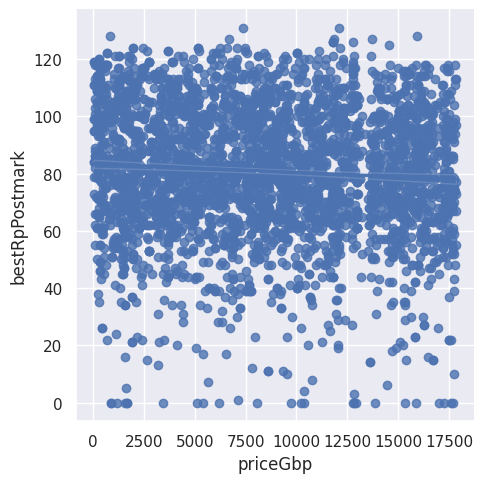

In [178]:
sns.lmplot(data = sale_rating_data, x = 'priceGbp', y = 'bestRpPostmark')
#####seems to be a massive error here. need to clean data

Staggering negetive correlation. this wasnt played out when compiling horse odds.

##### To do/ideas - predicting broodmare ability



*   First is build a model guesiing a mares future foal ratings. will need a few
*   Models based on the stage of her carear.
*   sisters of dams. If the sister is a good dam how strongly correlated is that?
*   Have been looking alot at means. how about maxes? I feel the market rewards the best out of a mare. Which is wrong from a stats point of view but have to play the game. I just have to try and see where race course ability ties into a broodmare ability/reward in sales ring.
* Tom wilson does alot on winners.
*   **more suitable damsire stats might help**. Right now would only have outdated data. Have to assign time to scraping the data bettet. Dam sire stats from a past point of view. Then also the lower tiers/generations being able to merge in mare stats. I didmt even use the stats on offer here. I could prob use them on newer sales that I have scraped.







#EDA mare profitability

knowing what we know about predicting broodmare ability using ratings and thier dams prog ratings (correlated).... its not very accurate unbless having 3/4 ish foals of a sample size, the more the better. Im going to look at what mares sold cheap but thier stock went on to make money and try see why that would have happened, or the edge might just be roll the dice for small money as the market over values too many things.

will be looking at what makes a foal or yearling profitable. mare ability will surely be an overplayed factor.  


In [179]:
#Im goinh to start a generation lower here. as we have dams name in the sales column. will be easy to shift up/down a generation.
own_sib_sales = all_data_sets['own_sib_sales']
own_sib_sales['id'] = own_sib_sales['damName'].astype(str) + "_" + own_sib_sales['horseYob'].astype(str) #creating an id that individualises the horses sales
own_sib_sales_young = own_sib_sales.loc[own_sib_sales['horseAge'] <= 2]
own_sib_sales_young.head()

,saleDate,lotNo,horseUid,horseName,horseSaleName,horseAge,horseYob,horseFirstColourCode,horseSecondColourCode,horseSex,...,buyerDetail,price,priceGbp,venueDesc,venueUid,curCode,vendor,sale_lot_no,relationship,id
4,2017-10-25,1090,NaN,NaN,NaN,1,2016,NaN,NaN,C,...,Withdrawn,NaN,NaN,FASIG-TIPTON,7,USD,Taylor Made Sales Agency,1376,sib_sales,Gozlan_2016
5,2017-10-25,1090,NaN,NaN,NaN,1,2016,NaN,NaN,C,...,Withdrawn,NaN,NaN,FASIG-TIPTON,7,USD,Taylor Made Sales Agency,1376,sib_sales,Gozlan_2016
10,2014-10-15,1233,1413690.0,Pride Of Angels,PRIDE OF ANGELS,1,2013,GR,NaN,F,...,Simon Crisford,65000.0,68250.0,TATTERSALLS,5,GNS,From Longview Stud Ltd.,1377,sib_sales,Openness_2013
12,2013-05-07,13,870903.0,Painted Black,PAINTED BLACK,2,2011,BR,NaN,C,...,Withdrawn,NaN,NaN,BADEN-BADEN,25,EUR,From Huggan BS,1377,sib_sales,Openness_2011
13,2012-10-25,44,809768.0,Almanack,ALMANACK,2,2010,B,NaN,C,...,Withdrawn,NaN,NaN,GOFFS,3,EUR,From Thomastown Castle,1377,sib_sales,Openness_2010


In [180]:
max_own_sib_sales_young = own_sib_sales_young.groupby('id')['priceGbp'].idxmax().dropna()
max_own_sib_sales_young.head()

id
Abbeyville Miss_2009     9152.0
Absolute Music_2012     11678.0
Absolute Music_2013     11676.0
Absolute Music_2014     11675.0
Absolute Music_2019     11667.0
Name: priceGbp, dtype: float64

In [181]:
dams_mean_prog_max_rating.head()

,mean_dams_prog_rating,count_dams_prog_ratings
sale_lot_no,,
1376,66.0,2
1377,65.5,4
1378,80.8,5
1380,62.2,5
1381,82.0,8


In [182]:
dams_df.head()

,horseName,bestRpPostmark,mean_dams_prog_rating,count_dams_prog_ratings,scnd_dams_mean_prog_ratings,count_scnd_dams_prog_ratings,bestRpPostmark_bin,saleDate,priceGbp,horseYob,log_dams_yr_price
sale_lot_no,,,,,,,,,,,
1379,Grace O'Malley,101.0,NaN,NaN,99.666667,6,"(95.0, 105.0]",2007-10-09,147000.0,2006.0,11.898188
1380,Sister Red,82.0,62.200000,5.0,79.666667,6,"(75.0, 85.0]",2009-08-25,22000.0,2008.0,9.998798
1381,Fabulous Fairy,77.0,82.000000,8.0,85.000000,5,"(75.0, 85.0]",NaN,NaN,NaN,NaN
1383,Gleaming Water,NaN,86.000000,8.0,76.500000,6,NaN,NaN,NaN,NaN,NaN
1384,Bright Halo,NaN,80.727273,11.0,97.900000,10,NaN,NaN,NaN,NaN,NaN


##### Mare profitablity to do

Keep going haha. Just leaving space here for now


#### Overall to do

New section - look at sale. see what stats the mares had coming in and test a few theories. Then see what the future held for them.